# Hypothysis

Base on the assersion that:

1. It is common that the scientests working with a data set know and understand the shape of the dataset
2. Files in a data set are named such that filenames/paths can be derived for any given chunk of data

It should be possiable to create a 'hyper' cube based purely on 'theoretical' data that is supplied by the data set curator.

A question remains of how safe this is, if the some of the data is missing or curupt or the curator is wrong in their assumptions about the files is there a danger of being 'lied to' by the data or will the data access simply fail gracefully (or some other defined behaviour such as return NaN, None, Null, etc).


## What data...

In [121]:
import netCDF4
import glob
import iris
import os
import warnings
import cf_units 
import dask.array as da

In [114]:
data_dir = '/s3/informatics-eupheme/'
sub_dir = data_dir + 'HadGEM3-A-N216/historical/tas/Amon/'
sub_dir

import glob
files = sorted(glob.glob(sub_dir + '*.nc'))
print("%s files e.g..." % len(files))
print('\n'.join(files[:3]))

90 files e.g...
/s3/informatics-eupheme/HadGEM3-A-N216/historical/tas/Amon/tas_Amon_HadGEM3-A-N216_historical_r1i1p10_196001-196912.nc
/s3/informatics-eupheme/HadGEM3-A-N216/historical/tas/Amon/tas_Amon_HadGEM3-A-N216_historical_r1i1p10_197001-197912.nc
/s3/informatics-eupheme/HadGEM3-A-N216/historical/tas/Amon/tas_Amon_HadGEM3-A-N216_historical_r1i1p10_198001-198912.nc


Explore the files to see what is in them

In [81]:
sorted([os.path.basename(f) for f in files])

['tas_Amon_HadGEM3-A-N216_historical_r1i1p10_196001-196912.nc',
 'tas_Amon_HadGEM3-A-N216_historical_r1i1p10_197001-197912.nc',
 'tas_Amon_HadGEM3-A-N216_historical_r1i1p10_198001-198912.nc',
 'tas_Amon_HadGEM3-A-N216_historical_r1i1p10_199001-199912.nc',
 'tas_Amon_HadGEM3-A-N216_historical_r1i1p10_200001-200912.nc',
 'tas_Amon_HadGEM3-A-N216_historical_r1i1p10_201001-201312.nc',
 'tas_Amon_HadGEM3-A-N216_historical_r1i1p11_196001-196912.nc',
 'tas_Amon_HadGEM3-A-N216_historical_r1i1p11_197001-197912.nc',
 'tas_Amon_HadGEM3-A-N216_historical_r1i1p11_198001-198912.nc',
 'tas_Amon_HadGEM3-A-N216_historical_r1i1p11_199001-199912.nc',
 'tas_Amon_HadGEM3-A-N216_historical_r1i1p11_200001-200912.nc',
 'tas_Amon_HadGEM3-A-N216_historical_r1i1p11_201001-201312.nc',
 'tas_Amon_HadGEM3-A-N216_historical_r1i1p12_196001-196912.nc',
 'tas_Amon_HadGEM3-A-N216_historical_r1i1p12_197001-197912.nc',
 'tas_Amon_HadGEM3-A-N216_historical_r1i1p12_198001-198912.nc',
 'tas_Amon_HadGEM3-A-N216_historical_r1i

In [115]:
def describe(file):
    print("file path %s" % file)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for cube in iris.load_raw(file):
            print(cube)
            print('\n\n')

describe(files[0])
describe(files[20])
describe(files[-1])

file path /s3/informatics-eupheme/HadGEM3-A-N216/historical/tas/Amon/tas_Amon_HadGEM3-A-N216_historical_r1i1p10_196001-196912.nc
air_temperature / (K)               (time: 120; latitude: 324; longitude: 432)
     Dimension coordinates:
          time                           x              -               -
          latitude                       -              x               -
          longitude                      -              -               x
     Scalar coordinates:
          height: 1.5 m
     Attributes:
          Conventions: CF-1.4
          associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: gridspec_atmos_fx_HadGEM3-A-N216_historical_r0i0p0.nc...
          branch_time: 0.0
          cmor_version: 2.9.1
          contact: peter.stott@metoffice.gov.uk, andrew.ciavarella@metoffice.gov.uk
          creation_date: 2015-07-31T05:55:16Z
          experiment: historical
          experiment_id: historical
          forcing: GHG, Oz, LU, Sl, 

Look to be files of just 'air_temperature' on the same grid. `time` always 120 steps. Let's look into the 'points' on that axis more

In [82]:
basename = 'tas_Amon_HadGEM3-A-N216_historical_r1i1p15_201001-201312.nc' # 'tas_Amon_HadGEM3-A-N216_historical_r1i1p1_196001-196912.nc'
file = os.path.join(data_dir, sub_dir, basename)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cubes = iris.load_raw(file)
assert len(cubes) == 1 # Belive true from above investigation

cube = cubes[0]
tcoord = cube.coord('time')
print("given file name file %s" % os.path.basename(file))
print("times (%s) :" % tcoord.units)
print (' '.join("%s (%s)" % (p, tcoord.units.num2date(p)) for p in cube.coord('time').points))


given file name file tas_Amon_HadGEM3-A-N216_historical_r1i1p15_201001-201312.nc
times (days since 1960-01-01) :
18015.0 (2010-01-16 00:00:00) 18045.0 (2010-02-16 00:00:00) 18075.0 (2010-03-16 00:00:00) 18105.0 (2010-04-16 00:00:00) 18135.0 (2010-05-16 00:00:00) 18165.0 (2010-06-16 00:00:00) 18195.0 (2010-07-16 00:00:00) 18225.0 (2010-08-16 00:00:00) 18255.0 (2010-09-16 00:00:00) 18285.0 (2010-10-16 00:00:00) 18315.0 (2010-11-16 00:00:00) 18345.0 (2010-12-16 00:00:00) 18375.0 (2011-01-16 00:00:00) 18405.0 (2011-02-16 00:00:00) 18435.0 (2011-03-16 00:00:00) 18465.0 (2011-04-16 00:00:00) 18495.0 (2011-05-16 00:00:00) 18525.0 (2011-06-16 00:00:00) 18555.0 (2011-07-16 00:00:00) 18585.0 (2011-08-16 00:00:00) 18615.0 (2011-09-16 00:00:00) 18645.0 (2011-10-16 00:00:00) 18675.0 (2011-11-16 00:00:00) 18705.0 (2011-12-16 00:00:00) 18735.0 (2012-01-16 00:00:00) 18765.0 (2012-02-16 00:00:00) 18795.0 (2012-03-16 00:00:00) 18825.0 (2012-04-16 00:00:00) 18855.0 (2012-05-16 00:00:00) 18885.0 (2012-06-

So it looks like the filename is `tas_Amon_HadGEM3-A-N216_historical_r1i1pP_YYYYMM-YYYYMM.nc` where YYYY MM are the start and stop dates in the file and are inclusive. P is the "physics version" as an int. Times in the file are for 12 months * 10 years = 120 timesteps. P is 1 to 15. 

Files start at `196001-` and end at `201001-` and inc by 10 years so `196001-196912`, `200001-200912`. The last file `201001-` is the exception and ends at `201312`

In [141]:
TUNIT = 'days since 1960-01-01'
VNAME = 'tas'

# Convert a date (in 360 day calendar to a number in units days since 1960-01-01)
def date_to_num(year, month, day):
    syear, smonth, sday = TUNIT.rstrip().split(' ')[-1].split('-')
    assert sday == smonth and int(sday) == 1
    assert TUNIT.strip().startswith('days since')
    start_year = int(syear)
    return (year - start_year) * 360 + (month - 1 )* 30 + ( day -1)


print(date_to_num(1969, 12, 16))# should be 3585
print(date_to_num(1963, 6, 16))# 1245.0 
print(date_to_num(1960, 1, 16))# 15.0 

3585
1245
15


In [83]:
first_date = (1960, 1, 16)
last_date = (2013, 12, 16)

current = date_to_num(*first_date)
time_coord_points=[]
while current <= date_to_num(*last_date):
    time_coord_points.append(current)
    current+=30

physics_coord_points = list(range(1,16))

print("time_coord_points: %s ... %s" % (all_dates[:5], all_dates[-5:]))
print("physics_coord_points: %s" % physics_coord_points)

time_coord_points: [15, 45, 75, 105, 135] ... [19305, 19335, 19365, 19395, 19425]
physics_coord_points: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [118]:
def file_details(time_index, pysics_index):
    time = cf_units.num2date(time_coord_points[time_index], TUNIT,cf_units.CALENDAR_STANDARD)
    syear = str(time.year)[:3] + '0'
    eyear = syear[:3] + '9' 
    shape = (120, 324, 432) 

    if syear == '2010':
        eyear = '2013'
        shape = (48, 324, 432) 
    
    basename = "tas_Amon_HadGEM3-A-N216_historical_r1i1p{physics}_{syear}01-{eyear}12.nc".format(
        syear=syear, eyear=eyear, physics=(pysics_index +1))
    path =  os.path.join(data_dir, sub_dir, basename)
    
    return path, shape
    
file_details(len(time_coord_points)-1, 4)
file_details(0, 4)

('/s3/informatics-eupheme/HadGEM3-A-N216/historical/tas/Amon/tas_Amon_HadGEM3-A-N216_historical_r1i1p5_196001-196912.nc',
 (120, 324, 432))

## Combining

Two ways spring to mind. One go through all the files and create a `iris.fileformats.netcdf.NetCDFDataProxy` for each file, wrap with a dask array and then concat and stack those arrays in to one. 

Other option is to extend/implement an equivilant to `iris.fileformats.netcdf.NetCDFDataProxy` that looks up the path on the file based on the 'keys' passed in to `__getitem__`

### Option 1

In [154]:
found=[]
notfound=[]
lastfile = None
p_arrays = []
dim_order = ['physics', 'time', 'lat', 'lon']
for p in range(0, len(physics_coord_points), 3):
    t_arrays = []
    for t in range(0, len(time_coord_points), 9):
      
        file, shape = file_details(t, p)
        if os.path.exists(file):
            found.append(file)
        else:
            notfound.append(file)
            
        if file != lastfile:
            data = iris.fileformats.netcdf.NetCDFDataProxy(
                shape,
                'float32',
                file,
                VNAME,
                None)
            data = da.from_array(data, data.shape)
            t_arrays.append(data)
        
        lastfile = file
    p_arrays.append(da.concatenate(t_arrays,0))
    
data = da.stack(p_arrays, 0)
print("Found %s. Not found %s" % (len(found), len(notfound)))

Found 360. Not found 0


In [ ]:
data[1,1,3,:].compute()

In [158]:
some_data = t_arrays[0][3,:,:]
some_data.compute()

array([[219.57617, 219.63208, 219.66211, ..., 219.84619, 219.8833 ,
        220.06323],
       [218.98706, 218.94824, 218.97241, ..., 219.1726 , 219.0105 ,
        218.89185],
       [217.84033, 217.84204, 217.80566, ..., 218.02783, 217.9497 ,
        217.8728 ],
       ...,
       [251.4961 , 251.48975, 251.47437, ..., 251.53369, 251.52515,
        251.51465],
       [251.38867, 251.38916, 251.39062, ..., 251.41138, 251.40894,
        251.40454],
       [251.3899 , 251.39355, 251.39404, ..., 251.40576, 251.39917,
        251.40039]], dtype=float32)

In [167]:
p_arrays[0][4:5:1].compute()

array([[[217.94067, 217.94043, 217.95068, ..., 218.2085 , 218.22656,
         218.41455],
        [219.37524, 219.35645, 219.38037, ..., 219.51001, 219.33716,
         219.14893],
        [220.146  , 220.1477 , 220.13867, ..., 220.22314, 220.17676,
         220.13745],
        ...,
        [264.38477, 264.3711 , 264.35938, ..., 264.4065 , 264.4004 ,
         264.3933 ],
        [264.29492, 264.29492, 264.2898 , ..., 264.32666, 264.31763,
         264.3103 ],
        [264.26514, 264.2578 , 264.25757, ..., 264.27417, 264.2732 ,
         264.26807]]], dtype=float32)

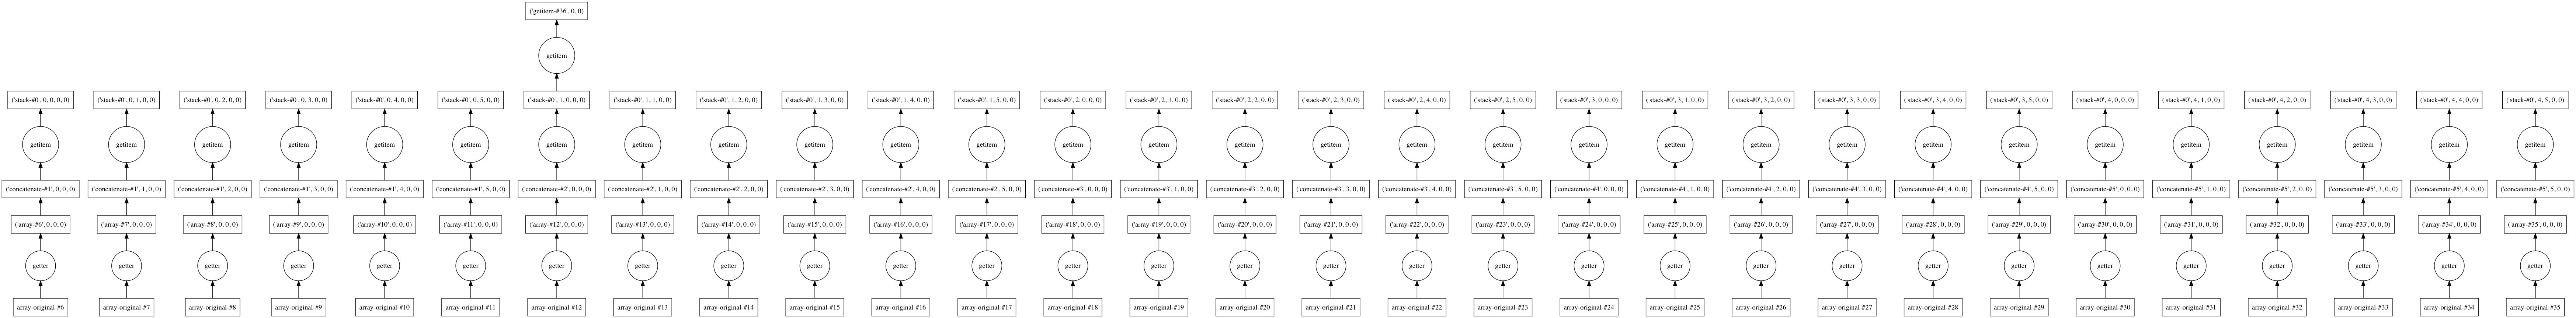

In [182]:
dall = da.stack(p_arrays, 0)
dall[1:2, 22, 2, :].visualize()
# dall[1:2, 22, 2, :].compute()

In [186]:
task = data[2, 6, :, :]
task.compute()

array([[211.54956, 211.40771, 211.32642, ..., 211.80835, 211.81909,
        212.31714],
       [211.72803, 211.90796, 211.96704, ..., 212.17114, 211.83813,
        211.51733],
       [214.0332 , 214.05737, 214.0625 , ..., 214.14502, 214.05908,
        214.00757],
       ...,
       [273.15625, 273.15625, 273.15796, ..., 273.15454, 273.15552,
        273.15698],
       [273.1587 , 273.15747, 273.15674, ..., 273.16113, 273.16113,
        273.16016],
       [273.17505, 273.1748 , 273.17505, ..., 273.17603, 273.17603,
        273.17554]], dtype=float32)

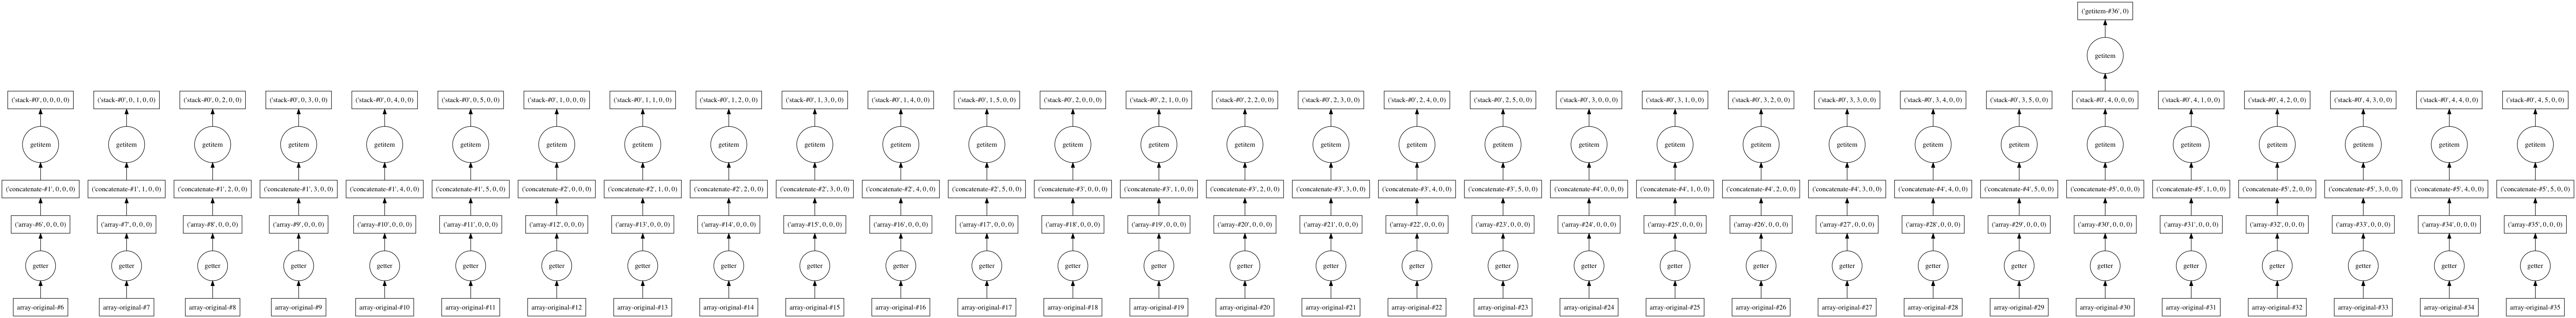

In [153]:
task.visualize()

In [ ]:
# an implemntation of iris.fileformats.netcdf.NetCDFDataProxy
class NetCDFDataProxy(object):
    """A reference to the data payload of a single NetCDF file variable."""

    __slots__ = ('shape', 'dtype', 'path', 'variable_name', 'fill_value')

    def __init__(self, shape, dtype, path, variable_name, fill_value):
        self.shape = shape
        self.dtype = dtype
        self.path = path
        self.variable_name = variable_name
        self.fill_value = fill_value

    @property
    def ndim(self):
        return len(self.shape)

    def __getitem__(self, keys):
        dataset = netCDF4.Dataset(self.path)
        try:
            variable = dataset.variables[self.variable_name]
            # Get the NetCDF variable data and slice.
            var = variable[keys]
        finally:
            dataset.close()
        return np.asanyarray(var)

    def __repr__(self):
        fmt = '<{self.__class__.__name__} shape={self.shape}' \
              ' dtype={self.dtype!r} path={self.path!r}' \
              ' variable_name={self.variable_name!r}>'
        return fmt.format(self=self)

    def __getstate__(self):
        return {attr: getattr(self, attr) for attr in self.__slots__}

    def __setstate__(self, state):
        for key, value in six.iteritems(state):
            setattr(self, key, value)